# **Heritage**

**...an AI query system for The Nigerian Peoples, their Pre-historic Arts, & Cultures.**

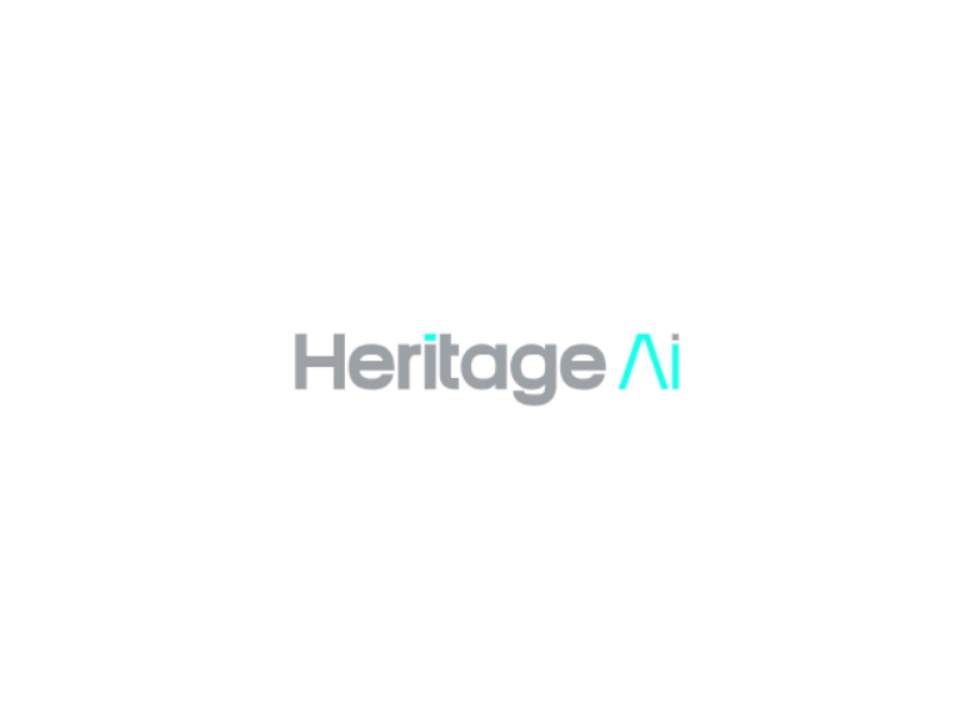

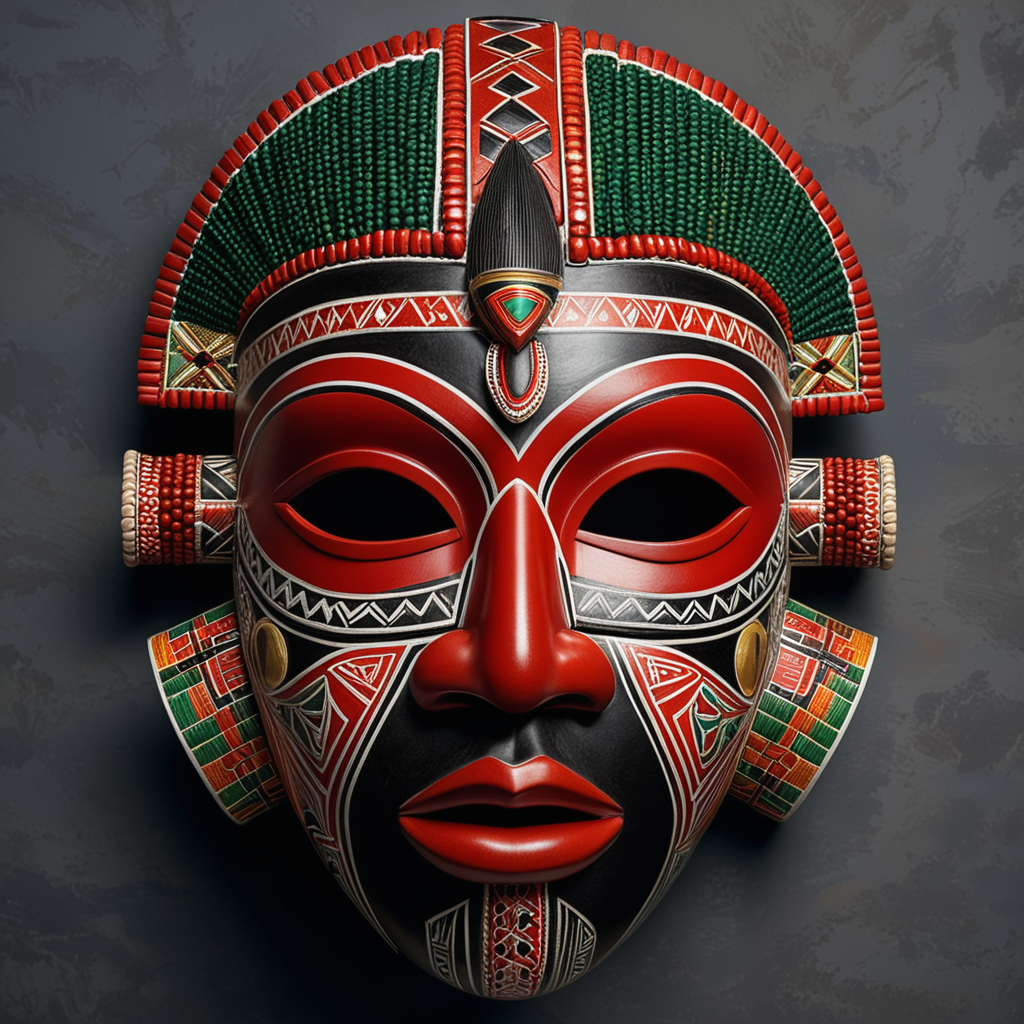


## **Introduction**

### 1. Project Background:

* Heritage is an innovative AI initiative aimed at making the rich, diverse culture and pre-historic art of Nigeria accessible and interactive.
* Leveraging Generative AI, Heritage seeks to address the need for quick, intuitive access to Nigerian cultural information, including visual descriptions of art styles, traditions, and historical significance.

### 2. Purpose:

* To create an immersive AI query system that enables users—both Nigerian culture enthusiasts and curious global audiences—to explore and learn about Nigerian heritage in an engaging way.
* By providing textual and visual descriptions, this system goes beyond static information, encouraging users to explore with ```imagination and curiosity```.

 ## **Hackathon Goals**

In Partnership with TensorOps & DiamantAI:

* Heritage will be developed as part of the TensorOps hackathon, which emphasizes innovation in AI agents. This project aligns perfectly with the hackathon’s theme by ```creating an interactive cultural guide agent```.
* As part of this hackathon, Heritage aims to become a contributor to the GenAI-Agents repository, showcasing Nigeria's history and culture through generative AI.

## **Project Overview**

Key Features:

* Natural Language Query Handling: Users can ask questions about Nigerian history, ethnic groups, art styles, and traditions, receiving informative, AI-generated responses.
* Visual Descriptions of Art: With the aid of AI, Heritage will generate rich descriptions and visualizations of Nigerian art forms, helping users imagine these historical pieces.
* Agent Architecture: The Heritage agent will use conversational AI, embeddings, and retrieval mechanisms to answer queries in real-time, facilitating easy access to Nigeria’s cultural legacy.

## **Submission**

Submission Process:

* Following the hackathon guidelines, Heritage will be submitted to the GenAI-Agents repository via a pull request, along with a the following tutorial on the system's setup, structure, and usage.

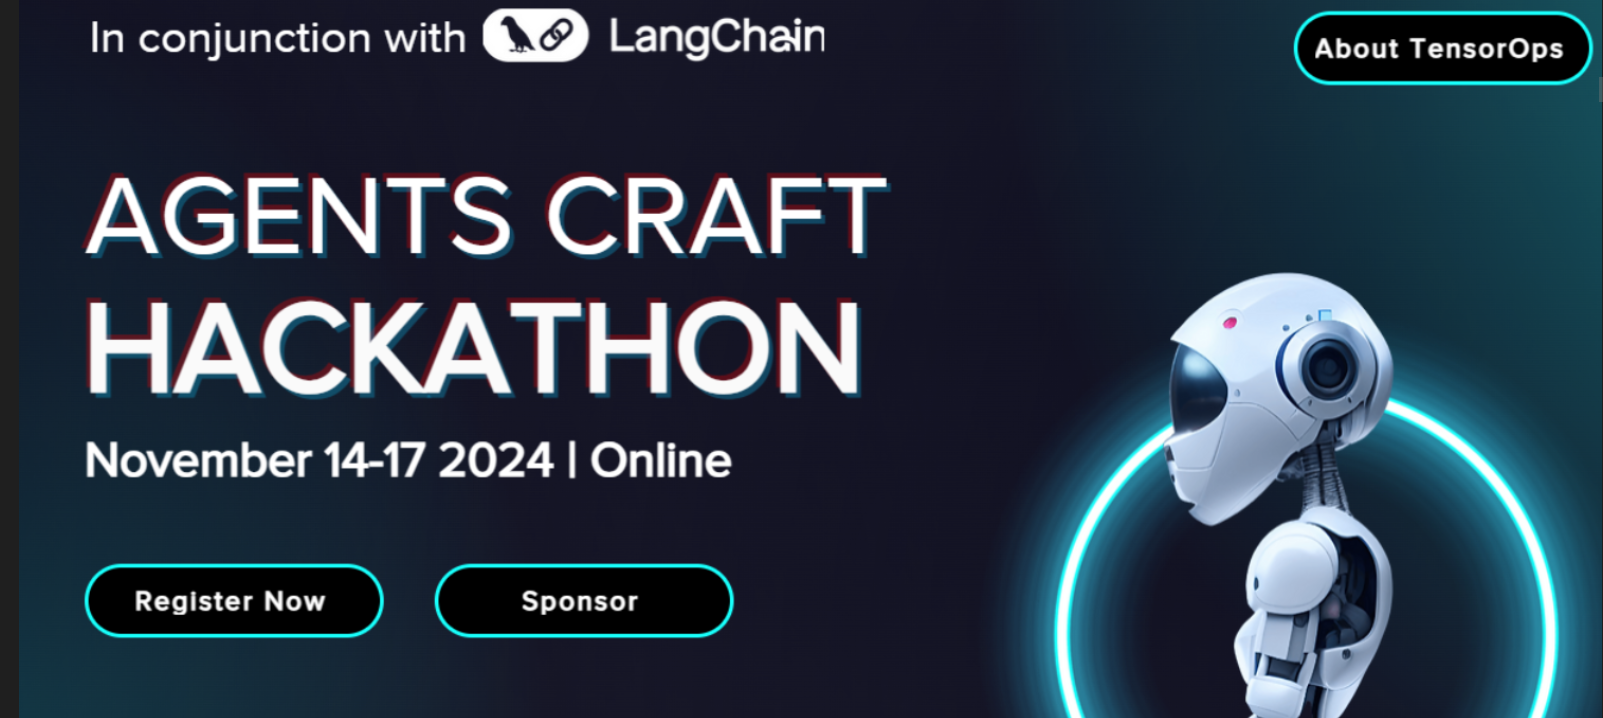

## **Before I Begin**

Hi! I'm  [🅱🅻🅰🆀](https://www.linkedin.com/in/chinonsoodiaka/).

This is my submission for the ```Agentscraft Hackathon``` 2024.


A few things you should know...

* This solution is an agentic chatbot with integrated image generation capabilities, designed to provide a rich, interactive experience. The workflow leverages ```LangGraph``` components, along with ```Tavily``` and a ```Gradio tool```, creating a seamless system for user interactions.

* The best part? This system operates at ```zero``` cost — no additional expenses required. However, to unlock its full potential, you'll need a few API keys to enable all features.

* One of the key advantages of this setup is its flexibility. The theme or use case of this chatbot can be effortlessly customized. While it's currently focused on ```Heritage``` you could easily adapt it to something entirely different — like "Space" — as long as you have a knowledge base that supports the new theme. Each component is modular and can be swapped out for alternatives without disrupting the overall structure.

With that said, let’s dive into it!

## **Heritage Architecture**

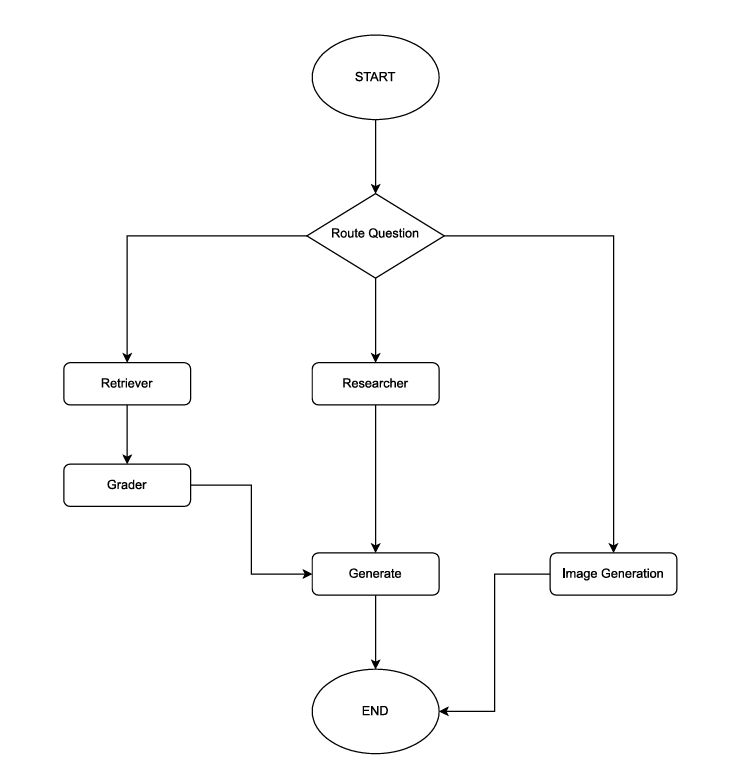

The core functionality of this system revolves around routing user queries to one of three branches: the RAG (Retrieval-Augmented Generation) branch, the internet branch, or the image generation branch.

* RAG branch handles queries that might be answered by data stored in the vector database.
* Internet branch is activated when the query isn’t found in the database and requires online information.
* Image generation branch manages queries that involve visualization or image-based responses.

A routing node directs each query to the appropriate branch based on its nature.

* When a query is routed to the RAG branch, the retriever node intercepts it, using the query to search the database and retrieve documents with similar meaning. These retrieved documents then go through the grader node, which evaluates their relevance. Only the most contextually relevant documents are passed on as context to the generator node. Finally, the generator node crafts a response to the user query based on the knowledge gathered from previous steps.
* When a query is directed to the Internet branch, the system initiates a research process to gather relevant documents from the web based on the query. These documents are then passed to the Generator node to provide additional context and produce a response.
* When a query is directed to the Image Generation branch, it triggers a request to this live [Gradio text-to-image tool](https://huggingface.co/spaces/prithivMLmods/Text-to-Image) hosted on Hugging Face Spaces. The generated image is returned to the user.


This structure forms the core of the system. However, to create a truly robust solution, additional points of action and conditional logic are required to enhance functionality and flexibility.

I will start by building out the different components of the application.

## **Install and Import Python Packages**

In [ ]:
! pip install -qU \
    langchain-qdrant==0.1.4 \
    langchain-huggingface==0.1.2 \
    pymupdf==1.24.13 \
    langchain_community==0.3.5 \
    langgraph==0.2.44 \
    tavily-python==0.5.0 \
    gradio==5.4.0 \
    gradio-client==1.4.2 \
    langchain-groq==0.2.1


In [ ]:
# Standard
from datetime import date, datetime
import os
import getpass
from uuid import uuid4
from typing import List

# Visualization
from IPython.display import Image, display
from IPython.display import Image as IPImage

# LangChain Core
from langchain.prompts import PromptTemplate
from langchain.schema import AIMessage
from langchain.retrievers import EnsembleRetriever
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

# LangChain Community
from langchain_community.tools import TavilySearchResults
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_community.retrievers import SVMRetriever

# LangChain-Specialized
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from langchain_groq import ChatGroq
from gradio_client import Client

# 6. Qdrant
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Graph
from langgraph.graph import MessagesState, StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

Send your Api Keys to the environment.

In [ ]:
os.environ["HF_TOKEN"] = getpass.getpass("Enter your HuggingFace token: ")

os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

## **The Embeddings Model**

For this quick proof of concept, I chose a model from Hugging Face.

I wanted a reliable, open-source embeddings model and ultimately decided on ```all-mpnet-base-v2```, but you can explore other options [here](https://huggingface.co/spaces/mteb/leaderboard).

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

## **Qdrant - Vector Database Creation & Setup.**


In [ ]:
# Initialize Qdrant client

client = QdrantClient(":memory:")

# Check if the collection exists
collection_name = "heritage"
print("Vector store does not exist. Creating collection...")
client.create_collection(
        collection_name=collection_name,
        vectors_config=VectorParams(size=768, distance=Distance.COSINE)
    )

# Initialize the vector store
vector_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings,
)

print("Vector store is ready.")

* For my vectors configuration, I am using ```size=768``` because my embeddings model from Huggingface has dimension size equal to 768.
* For my indexing strategy, I will be using Cosine similarity since I will be making semantic retrievals.

## **Data Ingestion**

I gathered several academic PDFs on the diverse arts and cultures of Nigeria. Due to the 10MB file size limit for this hackathon, I couldn’t include as many documents as I would have liked. Currently, I have four PDFs stored in the /data directory:

* ```history of nigerian traditional arts.pdf```
* ```Nigerian arts - a short history by moses and osinachi.pdf```
* ```NigerianCultureandTraditions.pdf```
* ```perspectives on nigerian peoples and culture.pdf```

With all files organized in the same directory, loading the data using LangChain will be straightforward.

In [ ]:
loader = DirectoryLoader('./data/', glob="**/*.pdf", show_progress=True, loader_cls=PyMuPDFLoader)

In [ ]:
docs = loader.load()
len(docs)

Great, the data has been loaded successfully!

When ingesting documents into the vector store, I prefer to add unique ```id```s to each document for easier management and retrieval.

In [ ]:
uuids = [str(uuid4()) for _ in range(len(docs))]
vector_store.add_documents(documents=docs, ids=uuids)

Query the Database...

In [ ]:
results = vector_store.similarity_search_with_score(
    query="ife art form", k=1
)
for doc, score in results:
    print(f"* [SIM={score:3f}] {doc.page_content} [{doc.metadata}]")

Create the retriever...

In [ ]:
# Create retrievers
similarity_retriever = vector_store.as_retriever(search_kwargs={"k": 5})
svm_retriever = SVMRetriever.from_documents(docs, embeddings)

# Create ensemble retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[similarity_retriever, svm_retriever],
    weights=[0.7, 0.3])

In [ ]:
ensemble_retriever.invoke("Ife art")

### Where we are...

* Data loaded,
* index created, and
* retriever set up.

Now, it's time for the design process.

## **Components: Nodes, Conditional Edges, Schema.**

### Schema

The schema will build upon the ```MessagesState``` structure by customizing it to include three key variables: ```documents```, ```summary```, and ```query```.

* ```documents```: This variable stores data retrieved from either the retriever or the web search function, as these are the primary nodes responsible for providing context to generator.
* ```summary```: A concise representation of the entire conversation, which will be generated after the generation node based on specific logic.
* ```query```: The user’s extracted query, derived from the most recent interaction, and used to route the workflow appropriately.

In [ ]:
class CustomMessagesState(MessagesState):
    documents: List[str]
    summary: str
    query: str

### Nodes

These are simply **action points** on the graph.

* **Query Extractor**

This node extracts the latest user query from the message history to make it easily accessible by any node in the workflow.

Here's how it works:

* Retrieves the most recent user input from ```state["messages"]```, ensuring it captures the user's latest intent.
* Saves the extracted query as the variable ```query```, making it accessible to subsequent nodes.

In [ ]:
def extract_query(state: CustomMessagesState) -> dict:
    """
    Extracts the user's query from the current state and saves it as a variable `query` for use in subsequent nodes.

    Args:
        state (CustomMessagesState): The current state containing the user's messages.

    Returns:
        dict: Updated state with the extracted query.a
    """
    print("EXTRACTING QUERY...")

    # Return the updated state
    return {"query": state["messages"][-1].content}


* **A Generator**

    This node generates an answer to a user question based on provided context, utilizing a language model to respond accurately and concisely.

    Here's how it works:

    * Extracts the question and context from the state object. The user’s question is retrieved from ```state["query"]```. Relevant documents (context) are retrieved from ```state["documents"]```.
    * Defines a structured prompt to guide the response.
    * Combines the prompt, LLM, and output parser - ```StrOutputParser```, in a processing chain to generate the answer.
    * Executes the chain by passing the user question and context into rag_chain, resulting in a direct, relevant answer.
    * Returns the generated answer wrapped in an AIMessage format, suitable for the next stages in the workflow.

In [ ]:
def generate_node(state: CustomMessagesState) -> dict:
    """
    Generate an answer to a question based on provided context using the Groq model.

    Args:
        state (MessagesState): The state containing messages and context.

    Returns:
        dict: A dictionary containing the generated answer in AIMessage format.
    """

    print("RESPONDING...")
    # Retrieve the question from the state
    question = state["query"]

    # Retrieve the documents from the last message in the state
    documents = state["documents"]
    formatted_documents = documents

    # Define the prompt
    prompt = PromptTemplate(
        template="""Answer the question below based only on the provided context. Avoid responses like 'According to the provided context...' or
    'Based on the provided context...' — simply answer directly. If the context does not contain enough information, respond with 'I don't know.'

Question: {messages}
Context: {documents}""",
        input_variables=["messages", "documents"],
    )

    # Initialize the Groq LLM
    llm = ChatGroq(temperature=0, model_name="llama-3.1-70b-versatile")

    # Create the chain for generating the answer
    rag_chain = prompt | llm | StrOutputParser()

    # Invoke the chain with the question and formatted documents
    result = rag_chain.invoke({"messages": question, "documents": formatted_documents})

    # Wrap the result in an AIMessage to meet the required format
    return {"messages": [AIMessage(content=result)], "query": question }

* **A Retriever**

This node is designed to retrieve relevant documents related to Nigerian arts and culture based on user queries. It utilizes a language model to improve the query's relevance and ensures that the retrieved documents align with the theme of Nigerian cultural heritage.

Here's how it works:

* The original user query is extracted from the ```MessagesState```.
* The query is enhanced by passing it through a query-improvement prompt, which utilizes the provided ```summary``` to refine the query for better relevance to Nigerian arts and culture.
* The improved query is then passed to the ```ensemble_retriever```, which searches the vector database for documents related to the refined query, specifically focusing on Nigerian culture.
* The retrieved documents are formatted into a list, ensuring they are contextually aligned with the user's request.
* The documents are returned in the state for subsequent stages, providing the necessary context for generating an accurate response.







In [ ]:
def retriever_node(state: CustomMessagesState) -> dict:
    """
    Retrieve relevant documents based on the user question, refining it to align with the Nigerian people's arts and culture theme.

    Args:
        state ( CustomMessagesState): The state containing the user question and summary.

    Returns:
        dict: A dictionary containing the retrieved documents.
    """
    print("RETRIEVING DOCUMENTS...")

    # Retrieve the summary from the state
    summary = state.get("summary", "")  # Make sure to fetch the summary if available


    # Define the query improvement prompt to align with Nigerian arts and culture
    improve_query_prompt = PromptTemplate(
        template="""
                You are participating in an on-going conversation between a user and a database system.
        Your task is to enhance the search query so that it accurately captures the correct answers based on the user's intent.

        Instructions:

        Generate a single, precise, improved query.
        Keep it relevant and focused on the conversation's context.
        Example 1 (Disjoint Queries):
        Conversation Summary:
        The conversation was about the location of the Igbo-Ukwu art in Nigeria. The answer provided was Anambra State.

        Original Query:
        In what year did the Benin art originate?

        Improved Query:
        The original query is unrelated to the previous conversation about Igbo-Ukwu art. The improved query should not
         attempt to connect the two.

        Correct Improved Query:
        In what year did the Benin art originate?

        Example 2 (Connected Queries):
        Conversation Summary:
        The conversation was about the location of the Igbo-Ukwu art in Nigeria. The answer provided was Anambra State.

        Original Query:
        Woah! Show me their art.

        Improved Query:
        The original query references "their," which clearly ties back to Igbo-Ukwu art discussed previously. The improved query
        reflects this context.

        Correct Improved Query:
        Show me Igbo-Ukwu art from Anambra State, Nigeria.

        Task
        Conversation Summary:
        {summary}

        Original Query:
        {messages}

        Improved Query:
        """,
        input_variables=["summary", "messages"]
    )

    # Initialize the Groq LLM for query improvement
    llm = ChatGroq(temperature=0, model_name="llama-3.1-70b-versatile")

    # Get the original user question from the state
    original_query = state["query"]

    # Improve the query
    formatted_prompt = improve_query_prompt.format(summary=summary, messages=original_query)
    response = llm.invoke(formatted_prompt)
    improved_query = response.content.strip()  # Clean up the response text

    # Print the improved query (for debugging/logging purposes)
    print(f"Improved Query: {improved_query}")

    # Retrieve relevant documents using the improved query
    docs = ensemble_retriever.invoke(improved_query)
    documents = [doc.page_content for doc in docs]
    print(f"Retrieved documents: {documents}")

    # Return the retrieved documents as a list in a dictionary with 'documents' key
    return {"documents": documents, "query": improved_query}

* **Grader**

    This node assesses the relevance of retrieved documents to the user’s question, ensuring ONLY relevant documents proceed in the workflow. Here's how it works:

    * User question and retrieved documents are accessed from the MessagesState.

    * The user question is retrieved as the reference for evaluating document relevance. Each document is graded for relevance through a prompt-based LLM assessment.

    * A grading prompt instructs the model to compare the semantic similarity of each document to the user’s question. The model then assigns a binary   score: ```YES``` for relevant and ```NO``` for irrelevant.
    Only documents marked as relevant (```YES```) are retained.

    * Documents deemed relevant are concatenated into a single text ```docmnt``` for further analysis.
    An analyzer prompt evaluates if the retained document(s) fully address the user’s question.

    * Using a follow-up prompt, the model assesses if the content of ```docmnt``` is comprehensive enough to answer the question in full.
    
    Final Routing Decision:

    * If the document fully answers the question (```YES```), the node outputs generate_node, proceeding to generate a response.
    * If not (```NO```), the node outputs researcher, directing the query for additional research or alternative processing.

In [ ]:
def grader_node(state: CustomMessagesState) -> dict:
    """
    Grade the relevance of retrieved documents to a user question.

    Args:
        state (MessagesState): The state containing the user question and retrieved documents.

    Returns:
        dict: A dictionary containing either 'researcher' if NO count exceeds 2,
              or 'generate_node' if the documents are mostly relevant.
    """

    # Define the prompt for grading
    grader_prompt = PromptTemplate(
        template="""You are a grader assessing the relevance of a retrieved document to a user question.

        Here is the retrieved document:
        {document}

        Here is the user question:
        {messages}

        To assess the relevance of the document to the question, please use semantic similarity to compare the meaning of the document and the question. If the document contains information that is semantically similar to the user question, grade it as relevant. Do not be stringent with the keywords. The goal is to filter out erroneous retrievals.

        Give a binary score 'YES' to indicate that the document is relevant to the question, or 'NO' to indicate that the document is NOT relevant to the question.

        Provide the binary score as plain text with no preamble or explanation.
        """,
        input_variables=["messages", "document"],
    )

    # Initialize the Groq LLM
    llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")

    print("GRADING RETRIEVED DOCUMENTS...")
    # Get the user question from the state
    question = state["query"]

    # Get the retrieved documents from the last entry in the messages
    documents = state["documents"]  # Assuming the retriever node set this

    no_count = 0
    docmnt = ""

    # Loop through each document to grade its relevance
    for doc in documents:
        # Generate the prompt for the current document
        formatted_prompt = grader_prompt.format(messages=question, document=doc)

        # Invoke the LLM with the formatted prompt
        response = llm.invoke(formatted_prompt)
        #print(f"GRADE: {response.content.strip().upper()}")

        # Check if the response is 'NO' and increment the counter if it is
        if response.content.strip().upper() == 'YES':
            docmnt += doc

    # Define the prompt for analyzing
    analyzer_prompt = PromptTemplate(
        template="""You are an analyzer assessing whether a document completely answers a given query.

Document: {document}

Query: {messages}

Carefully examine if the document contains all necessary information to fully answer the question. Avoid relying on keyword similarity;
only respond 'YES' if the document definitively addresses the question in full. Otherwise, reply 'NO.'

Respond with a simple 'YES' or 'NO' without additional explanation.""",
        input_variables=["messages", "document"],
    )

    # Initialize the Groq LLM
    llm = ChatGroq(temperature=0, model_name="llama-3.1-70b-versatile")

    print("ANALYZING GRADES...")

    formatted_prompt = grader_prompt.format(messages=question, document=docmnt)
    # Invoke the LLM with the formatted prompt
    response = llm.invoke(formatted_prompt)



    if response.content.strip().upper() == 'YES':
        return {"messages": AIMessage(content="generate_node"), "documents":docmnt }

    # If NO count does not exceed 2, return 'generate_node'
    return {"messages": AIMessage(content="researcher")}

* **Off-Topic Response**

    This node acts as a ```Responsible AI guardrail``` to keep user interactions aligned with the intended scope of Nigerian arts, culture, and heritage.

    Here’s how it functions:

    * Generates a message that clearly states the chatbot's focus: The response informs users that the system is dedicated solely to discussions on Nigerian peoples, arts, and culture, setting boundaries on acceptable topics.
    * Appends the off-topic response to the message history in ```state["messages"]```, ensuring continuity in the conversation flow.
    * Returns the updated message state with the off-topic response, providing a courteous yet firm boundary for users who attempt to go outside the chatbot's purpose.

In [ ]:
def off_topic_response(state: CustomMessagesState) -> dict:
    """
    Generate an off-topic response using the substitute LLM.

    Args:
        state (MessagesState): The current graph state containing previous messages.

    Returns:
        dict: Updated state with the substitute LLM response.
    """

    # Create the off-topic message response
    message = "I'm Heritage; designed by 🅱🅻🅰🆀 to ONLY talk about Nigerian Peoples, Arts, and Culture."

    # Print the message (for debugging purposes)
    #print(message)

    # Return the updated state with a new list including the off-topic message
    return {"messages": state["messages"] + [AIMessage(content=message)]}

* **Router**

    This node serves as the Routing Logic for directing user inquiries to the appropriate response branches based on the classification of their questions related to Nigerian arts and culture.

    Here’s how it functions:

    * Question Analysis: The node receives a user query from the state and utilizes a pre-defined prompt template to classify the question into one of four categories: RAG, web_search, image_gen, or off_topic. This classification determines the subsequent action to take.
    * Response Routing: Based on the classification, the node directs the inquiry to the appropriate branch:

        * **Web Search**: If classified as web_search, the node prompts the system to fetch current information online.

        * **RAG**: If classified as RAG, it directs the query to the vector database for historical data retrieval.

        * **Image Generation**: If classified as image_gen, it triggers the image generation process for visual queries.
        
        * **Off-Topic**: If the question is categorized as off_topic, the node informs the user that their inquiry is outside the scope of the chatbot's focus on Nigerian arts and culture.

In [ ]:
# Get today's date
today_date = datetime.today()

prompt = PromptTemplate(
    template=f"""You are an expert at routing user questions to the appropriate data source related to Nigerian Arts and Culture History.
      Based on the provided question and conversation summary, please classify it into one of the following categories:

1. RAG: Questions related to Nigerian Arts and Culture History (including historical figures, art forms, cultural practices, traditions, etc.).
2. web_search: Questions about Nigerian Arts and Culture History that require up-to-date information and might need to be looked up online.
   Today's date is {today_date}.
3. image_gen: Questions involving an image.
4. off_topic: Questions that are personal enquiries, inappropriate comments, or queries unrelated to Nigerian Arts and Culture History.

Examples:
    What is the capital of France? -> "DATASOURCE":"off_topic"
    Show me how an igbo-ukwu artifact looks like -> "DATASOURCE":"image_gen"
    Who was a famous Nigerian painter in the 20th century? -> "DATASOURCE":"RAG"
    What is the current status of Nigerian museums? -> "DATASOURCE":"web_search"
    Can you tell me about Nigerian traditional dances? -> "DATASOURCE":"RAG"
    Who is leading the development of Nigerian contemporary art? -> "DATASOURCE":"web_search"
    What are some notable cultural festivals in Nigeria? -> "DATASOURCE":"RAG"
    Who is a prominent Nigerian sculptor today? -> "DATASOURCE":"web_search"
    How did Nigerian art influence African art as a whole? -> "DATASOURCE":"RAG"
    Generate an image of the Nok culture -> "DATASOURCE":"image_gen"
    When is the next major art exhibition in Nigeria? -> "DATASOURCE":"web_search"
    Will you marry me? -> "DATASOURCE":"off_topic"

If the question falls into one of these categories, respond with a JSON object containing a single key 'DATASOURCE', which value should be one of
 'RAG', 'web_search', or 'off_topic'. Please no preamble or explanation.

Summary: {{summary}}
Question: {{messages}}

JSON Response:
""",
    input_variables=["summary", "messages"],
)

# LLM
llm = ChatGroq(temperature=0, model_name="llama-3.1-70b-versatile")
question_router = prompt | llm | JsonOutputParser()

Run this:

```what will it look to build a local home in nok style?```.

In [ ]:
question = input("Query: ")
summary = ''
response = question_router.invoke({"messages": question, "summary": summary})

# Extract the value of 'DATASOURCE'
value = response.get("DATASOURCE", "No key found")
print(f"QUESTION and GRADE: {question} - {value}")

QUESTION and GRADE: what will it look to build a local home in nok style? - image_gen


Looks fine.

The node...

In [ ]:
def route_question(state: CustomMessagesState) -> dict:
    """
    Routes the question to either web search, vector database (RAG), or a fallback LLM response,
    utilizing the summary to improve understanding of the conversation context.

    Args:
        state (CustomMessagesState): The current state containing the user's question and conversation summary.

    Returns:
        dict: Contains the next node to call based on the classified data source and the query.
    """
    question = state["query"]
    # Initialize summary as an empty string if it's not set in the state
    summary = state.get("summary", "")

    print(f"Query: {question}")
    print(f"Summary: {summary}")
    print("ROUTING THIS QUERY APPROPRIATELY...")

    # Invoke the router with the question and summary
    route = question_router.invoke({"summary": summary, "messages": question})
    value = route.get("DATASOURCE", "No key found")


    # Determine which node to route to based on the returned data source value
    if value.lower() == 'web_search':
        print("SEARCH THE INTERNET.")
        message = "researcher"
    elif value.lower() == 'rag':
        print("QUERY DATABASE.")
        message = "retriever_node"
    elif value.lower() == 'image_gen':
        print("QUERY THE GENIE.")
        message = "genie_node"
    else:
        print("This query is off-topic.")
        message = "off_topic_response"

    return message


* **Online Search**

This node is responsible for refining the user's query using a language model and retrieving relevant information from ```Tavily search results```. It enhances the query's clarity and relevance, particularly focusing on Nigerian arts and culture, and fetches current data through advanced web search techniques.

Here’s how it functions:

* Query Refinement: The user’s original query is first refined using a LLM. The refinement aims to make the query more specific and relevant, especially regarding Nigerian arts and culture. The LLM enhances the clarity and relevance of the query, considering any available summary and ensuring the query is well-suited for a web search.

* Search Execution: The refined query is then passed to the Tavily tool. This tool performs an advanced search to gather relevant web content, including AI-generated answers and raw search results for further context.

* Result Aggregation: The retrieved search results, including URLs and their associated content, are formatted and combined into a cohesive output. This result provides the user with the most relevant information based on their refined query.

* Return Information: The combined search results, including both URL and content, are returned as a single response, which can be further processed or displayed to the user.

In [ ]:
def research(state: CustomMessagesState) -> dict:
    """
    Refines the user query with an LLM and retrieves relevant information via Tavily search results.

    Args:
        state (dict): The state containing the user's query and optionally a summary.

    Returns:
        dict: Contains relevant information from Tavily search results.
    """
    # Initialize TavilySearchResults tool
    tavily_tool = TavilySearchResults(
        max_results=3,                # Limit the number of search results
        search_depth="advanced",      # Use advanced search for better relevance
        include_answer=True,          # Include AI-generated answers from Tavily
        include_raw_content=True      # Retrieve raw content for added context
    )

    # Get the original query and summary from the state
    original_query = state["query"]
    summary = state.get("summary","")

    # Define the prompt for refining the query
    improve_query_prompt = PromptTemplate(
        template="""Refine the given question to enhance clarity and relevance.
        You will be provided a summary for context.
         Provide a single, concise sentence as the improved query.
        If recent information is needed, the current year is {date}.

        Context: {summary}

        Original Query: {messages}

        Improved Query:""",
        input_variables=["messages", "summary", "date"]
    )

    # Initialize the LLM (ChatGroq in this case)
    llm = ChatGroq(temperature=0, model_name="llama-3.1-70b-versatile")

    # Format the prompt with the original query and the current year
    formatted_prompt = improve_query_prompt.format(
        messages=original_query,
        summary=summary,
        date=date.today().year
    )

    # Refine the query using the LLM
    response = llm.invoke(formatted_prompt)
    improved_query = response.content.strip()

    # Perform the search using TavilySearchResults
    search_results = tavily_tool.invoke({"query": improved_query})

    # Combine search results into a single response
    combined_results = []
    for result in search_results:
        url = result.get("url", "Unknown URL")
        content = result.get("content", "No content available")
        combined_results.append(f"URL: {url}\nContent: {content}")

    # Return the combined results
    return {"documents": ["\n\n".join(combined_results)]}

* **Image Generator**:

    This node is responsible for generating and displaying an image based on the user's description provided in the conversation state.

    Here’s how it functions:

    * It extracts the image description from the latest user message stored in the state. This description serves as the prompt for image generation.
    * The node creates a client connection to a specified Gradio app, which is designed to generate images from text descriptions. This integration allows for seamless interaction with the image generation service. The node invokes the Gradio API, sending the extracted image description as a prompt. It uses a predefined seed for randomness, ensuring consistent image generation for identical prompts.
    * Upon receiving the generated image, the node extracts the image path from the API response. This path points to the location of the generated image.

First, let me use a chain to see an example of this image generation process with a ```Gradio tool```.

In [ ]:
messages = """Create an image of an ancient artifact from the Igbo-Ukwu culture in Nigeria, capturing intricate
 metalwork and symbolic patterns representative of the region's craftsmanship and history. Use realistic colors and textures
   typical of bronze and ceramic materials."""

In [ ]:
def generate_image_from_gradio(image_description, seed=42):
    """
    Generates an image based on a description by querying a Gradio API.

    Args:
        image_description (str): Description of the image to generate.
        seed (int): Optional seed for reproducibility.

    Returns:
        str: A clickable link to view the generated image or an error message.
    """
    # Create a client to connect to the Gradio app
    client = Client("prithivMLmods/Text-to-Image")  # Replace with your Gradio app's name

    # Prepare the input for the Gradio model
    text_input = image_description

    try:
        # Call the predict method to generate an image based on the text input
        output_image = client.predict(prompt=text_input, seed=seed)

        # Extract the image path from the output
        image_path = output_image[0][0]['image']  # Access the image path in response

        # Return clickable link for the user to view the generated image
        return f"Generated Photo: {image_path}"

    except Exception as e:
        # Handle any errors in the request
        return f"Error: Could not generate image. Details: {e}"

In [ ]:
print(generate_image_from_gradio(messages))

Works fine.

Now, the node...

In [ ]:
def display_node(state: CustomMessagesState) -> dict:
    """
    Generates and displays an image based on a refined description using the Gradio API.

    Args:
        state (CustomMessagesState): The current state containing the user's message and optional summary.

    Returns:
        dict: A dictionary containing the link to the generated image or an error message.
    """


    # Extract the image description and summary from the state
    user_query = state["messages"][-1].content
    summary = state.get("summary", "")  # Use an empty string if no summary exists

    # Initialize the LLM
    llm = ChatGroq(temperature=0.1, model_name="llama-3.1-70b-versatile")

    # Define a prompt template for refining the image description
    refine_prompt = PromptTemplate(
        template="""
        Craft a refined query of the initial user query that is concise yet detailed, enriching the query with more creative
         ideas in line with what the user asked for. Tailor the query
        to reflect the context in the summary for an exceptional image.
        The query should be just one sentence.

        user query: {messages}
        conversation summary: {summary}
        """,
        input_variables=["messages", "summary"]
    )

    # Generate the refined query using the LLM
    try:
        prompt_input = refine_prompt.format(messages=user_query, summary=summary)
        refined_description = llm.invoke(prompt_input).content.strip()
    except Exception as e:
        return {"messages": [f"Error: Could not refine the image description. Details: {e}"]}

    # Log the refined query for debugging
    print(f"Refined Description: {refined_description}")

    # Create a client to connect to the Gradio app
    client = Client("prithivMLmods/Text-to-Image")  # Replace with your Gradio app's name

    try:
        # Call the Gradio API to generate an image based on the refined description
        print("GENERATING IMAGE...")
        output_image = client.predict(prompt=refined_description, seed=42)

        # Extract the image path from the output
        image_path = output_image[0][0]['image']  # Access the image path in response

        # Display the image
        #img = Image.open(image_path)
        #plt.imshow(img)
        #plt.axis('off')  # Hide axis
        #plt.show()
        display(IPImage(filename=image_path))

        # Return clickable link for the user to view the generated image
        return {"messages": [f"<a href='file://{image_path}' target='_blank'>Click here to view the generated image</a>"]}

    except Exception as e:
        # Handle any errors in the request
        return {"messages": [f"Error: Could not generate image. Details: {e}"]}

* **Conversation Summarization**

This node is responsible for summarizing the ongoing conversation and retaining the key points for clarity and better context as the dialogue progresses. The summary is either extended or created from scratch, depending on whether there is an existing summary.

Here's how it works:

* Check for Existing Summary: The node first checks if a summary already exists in the state. If a summary is present, it is extended with the latest conversation messages.

* Summarization Prompt: A prompt is created based on whether an existing summary is found. If a summary is available, the prompt asks the model to extend it with the latest conversation. If no summary exists, the prompt instructs the model to generate a summary of the entire conversation so far.

* Generate the Summary: The prompt, along with the history of the conversation (including the new summary request), is sent to the model for generating the summary.

* Message Deletion: Once the summary is created, the node deletes all but the two most recent messages from the conversation to keep the message history manageable and focused. This helps in reducing clutter and maintaining performance by minimizing state size.

* Return Values: The function returns the new summary along with a list of messages to delete from the conversation history, which ensures that the summary remains up-to-date without overloading the context.

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage

def summarize_conversation(state: CustomMessagesState) -> dict:

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    llm = ChatGroq(temperature=0, model_name="llama-3.1-70b-versatile")
    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    # Delete all but the  most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-5]]
    return {"summary": response.content, "messages": delete_messages}

### Conditional Edges:

These are the logic that determine the overall flow of the graph.

* **decide-to-generate**

This immediately follows ```grader node```. This edge conditional is responsible for determining the next action in the process flow based on the content of the latest user message.

Here’s how it functions:

* The conditional retrieves the most recent message from the conversation state.
* It checks the content of the message against two specific keywords: "researcher" and "generate_node". Based on this check:

    * If the message is ```researcher```, the function will direct the flow to the researcher node.
    
    * If the message is ```generate_node```, the function will proceed to the generate_node.

So, in a nutshell, if the knowledge from the ```RAG branch``` is not enough to completely answer user's query, the workflow should involve the ```internet branch.```

In [ ]:
def decide_to_generate(state: CustomMessagesState) -> str:
    """
    Determines whether to proceed with the 'researcher' or 'generate_node' based on the message content.

    Args:
        state (MessagesState): The current graph state containing the decision message.

    Returns:
        str: Either 'researcher' or 'generate_node' based on the returned message.
    """

    print("MAKING A DECISION...")

    # Extract the decision message from the state
    decision_message = state["messages"][-1].content.strip().lower()
    decision_message = decision_message
    print(f"DECISION: {decision_message}")

    # Return the message directly if it's already "researcher" or "generate_node"
    if decision_message == "researcher":
        message = "researcher"
    elif decision_message == "generate_node":
        message = "generate_node"
    else:
        raise ValueError("Unexpected decision message content.")
    return message

* **summarize-or-not**

This node determines the next step in the conversation based on the number of messages exchanged. It serves as a conditional checkpoint to either end the conversation or trigger a summarization process, ensuring that the flow remains relevant and concise.

Here’s how it works:

* Message Count Check: The node evaluates the number of messages in the current conversation. If the conversation has exceeded three messages, it triggers the summarize_conversation node to provide a summary of the discussion.

* End or Summarize: If the number of messages is fewer than or equal to three, the node returns END, signaling that the conversation can be concluded at this point.

* Outcome: Based on the message count, the flow either moves forward to summarize the conversation or terminates the interaction altogether.

In [ ]:
from langgraph.graph import END
# Determine whether to end or summarize the conversation
def should_continue(state: CustomMessagesState) -> str:

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than three messages in the thread, then we summarize the conversation
    if len(messages) > 2:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

*Phew!*

That felt like a video game. It’s like I’ve just finished creating my characters and strategizing my game plan.

Okay, time to connect all these components and try out the application.

## **Graph**

In [ ]:
from IPython.display import Image

# Graph
builder = StateGraph(CustomMessagesState)

# Define nodes: these do the work
builder.add_node("retriever_node", retriever_node)
builder.add_node("off_topic_response", off_topic_response)
builder.add_node("researcher", research)
builder.add_node("extract_query", extract_query)
builder.add_node("generate_node", generate_node)
builder.add_node("grader_node", grader_node)
builder.add_node("genie_node", display_node)
builder.add_node("summarize_conversation", summarize_conversation)


# Define edges: these determine how the control flow moves
builder.add_edge(START, "extract_query")
builder.add_conditional_edges("extract_query",
    route_question,
    {
        "researcher": "researcher",
        "retriever_node": "retriever_node",
        "genie_node": "genie_node",
        "off_topic_response": "off_topic_response",
    },
)

builder.add_edge("researcher", "generate_node")
builder.add_edge("retriever_node", "grader_node")
builder.add_conditional_edges(
    "grader_node",
    decide_to_generate,{ "researcher": "researcher",
        "generate_node": "generate_node",}
)
builder.add_conditional_edges(
    "generate_node",
    should_continue,{ "summarize_conversation": "summarize_conversation",
        END: END,}
)
builder.add_conditional_edges(
    "genie_node",
    should_continue,{ "summarize_conversation": "summarize_conversation",
        END: END,}
)
builder.add_conditional_edges(
    "off_topic_response",
    should_continue,{ "summarize_conversation": "summarize_conversation",
        END: END,}
)
builder.add_edge("summarize_conversation", END)

memory = MemorySaver()
app = builder.compile(checkpointer=memory)

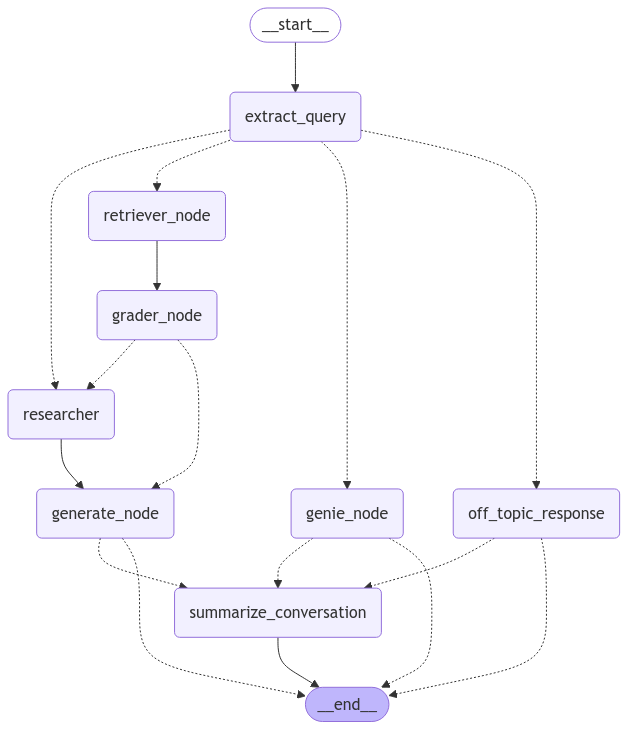

In [ ]:
# Display the image
app.get_graph().draw_mermaid_png(output_file_path="graph.png")
display(Image(filename="graph.png"))

Try it out:

In [ ]:
# In which state in nigeria can you find the igbo-ukwu art?
# In what year did the benin art originate?
# Who founded Tosode Artin  Nupe Kingdom and in what year did they found it?
# How might a festival mask from the Ekpe society look if it were combined with Afrofuturistic technology and design?
# What would a contemporary reinterpretation of Yoruba beaded crowns look like if they were designed for futuristic monarchs?
# what's the latest on Nigerian cultures today?
# which art is refered to as court art?
# which is the older of the two?
# How might Igbo uli body art patterns appear if transformed into glowing, neon tattoos in a cityscape setting?

In [ ]:
 # Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content=input("Query: "))]

# Run
messages = app.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()

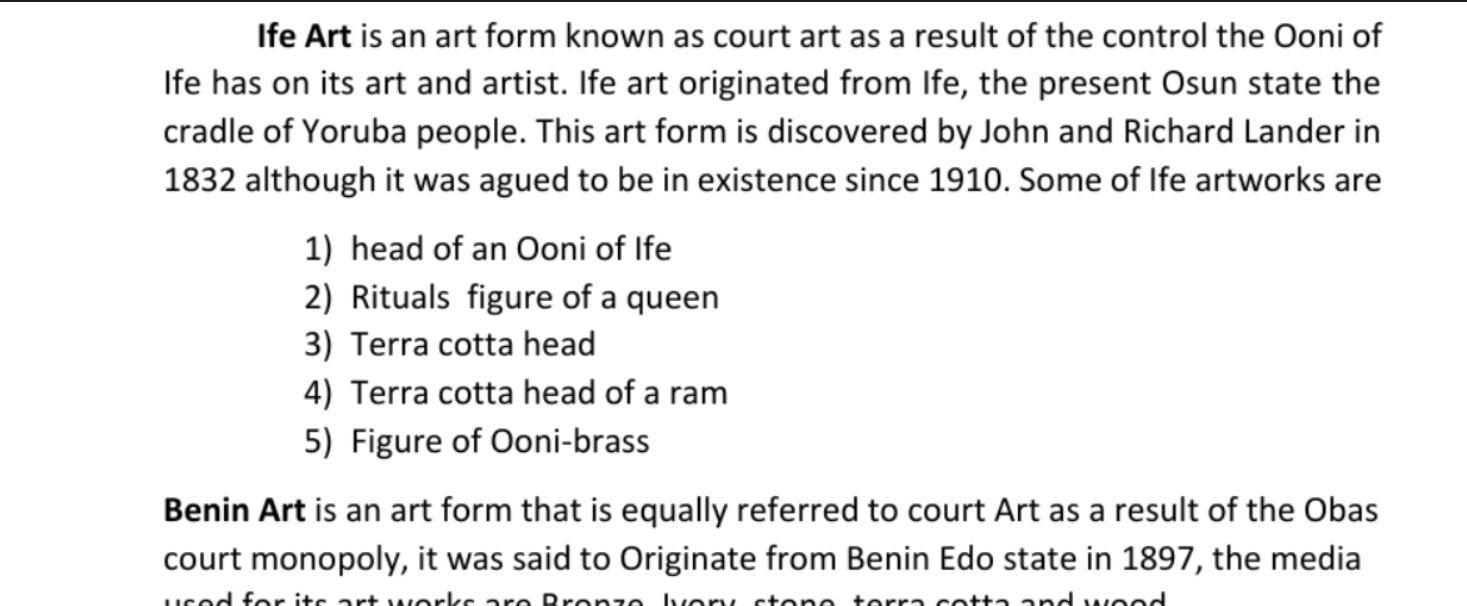

# **Final Remarks:**

Heritage is functioning well.

Looking ahead, I have several areas for improvement:

* I plan to explore enhanced embedding options, ideally using one of the state-of-the-art paid models. This should significantly enrich the augmented context, leading to improved hit rates and overall accuracy.

* I will rework the internet node to make it more roburst for scraping content from various websites, enabling it to gather more extensive information. This aligns with my goal of enriching the augmented context and improving the accuracy of responses.

* I have concerns about Qdrant as the vector database for an agentic use case, particularly regarding stability and latency issues, when scaling this kind of project up. I will explore other database options.

* I believe that investing in more powerful generative API tools with multimodal capabilities could significantly enhance the project. ```OpenAI's SORA text-to-video``` model would be a fantastic addition for Heritage, offering new possibilities for user interaction and content creation.